In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats 
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('tiktok_dataset.csv')
data.head(2)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0


In [3]:
data['author_ban_status'].value_counts()

author_ban_status
active          15663
under review     2080
banned           1639
Name: count, dtype: int64

In [4]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


In [5]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [6]:
data.shape

(19382, 12)

In [7]:
# Drop rows with missing values
data = data.dropna(axis=0)

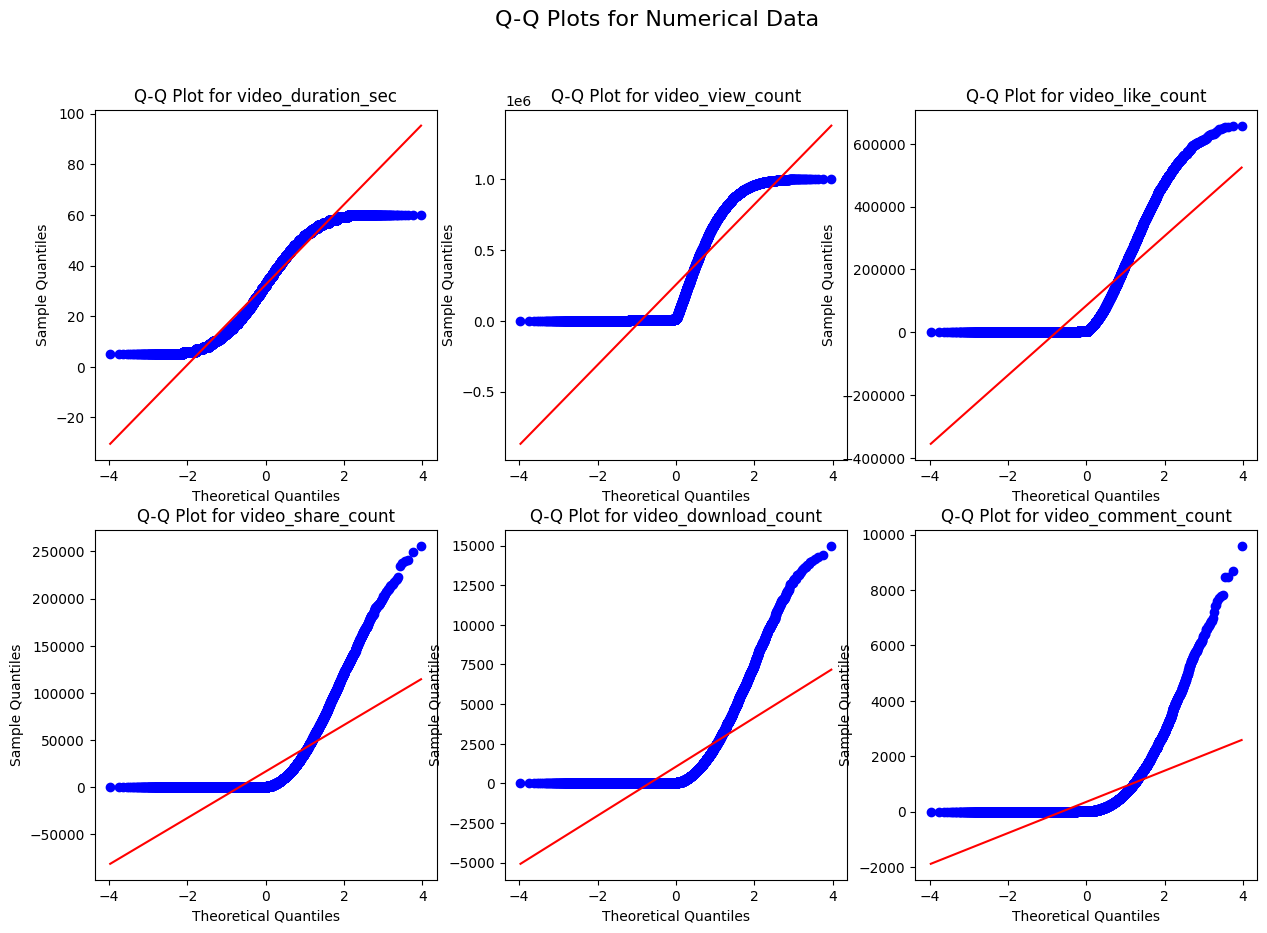

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Q-Q Plots for Numerical Data', fontsize=16)

columns_to_plot = ['video_duration_sec', 'video_view_count', 'video_like_count', 
                   'video_share_count', 'video_download_count', 'video_comment_count']

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    stats.probplot(data[column].dropna(), dist="norm", plot=axes[row, col])
    axes[row, col].set_title(f'Q-Q Plot for {column}')
    axes[row, col].set_xlabel('Theoretical Quantiles')
    axes[row, col].set_ylabel('Sample Quantiles')

In [9]:
zero_counts = data[['video_duration_sec', 'video_view_count', 'video_like_count', 
                    'video_share_count', 'video_download_count', 'video_comment_count']].eq(0).sum()

# Display the count of zeros in each column to the user
zero_counts

video_duration_sec         0
video_view_count           0
video_like_count           4
video_share_count         99
video_download_count     977
video_comment_count     3434
dtype: int64

We have a lot of 0 values, so we should apply log1p.

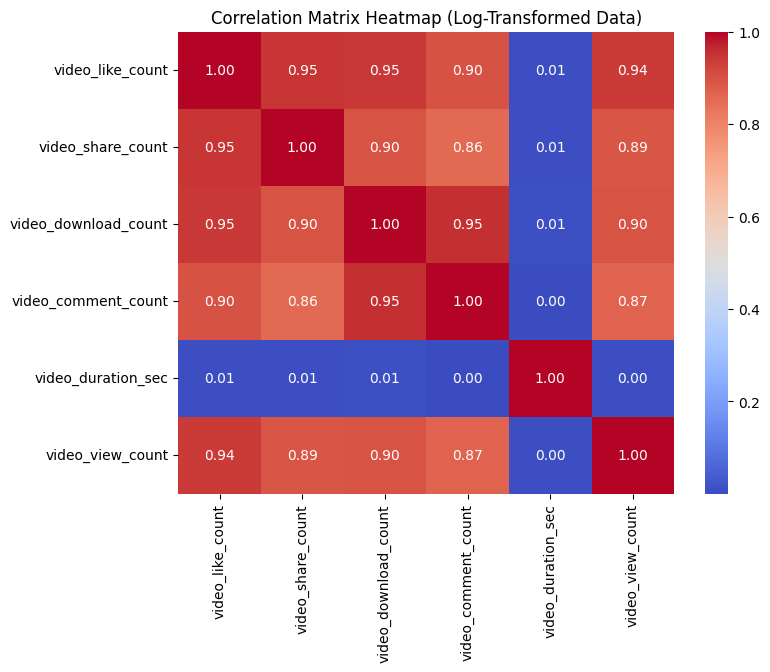

In [10]:
# Data with 0 
data_log_transformed = data[['video_like_count', 'video_share_count', 'video_download_count', 
                             'video_comment_count']].apply(np.log1p)

# Data without 0
data_log = data[['video_duration_sec', 'video_view_count']].apply(np.log)

# Concat the logs data
data_combined_transformed = pd.concat([data_log_transformed, data_log], axis=1)

correlation_matrix_log = data_combined_transformed.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap (Log-Transformed Data)')
plt.show()

High correlations (close to 1.0) are observed between several variables, such as:
- video_view_count and video_like_count (0.94)
- video_like_count and video_share_count (0.95)
- video_share_count and video_download_count (0.90)

The video_duration_sec has very low correlations with other metrics, suggesting that video duration might not significantly influence other metrics like views, likes, or comments after the transformation.


In [11]:
X = data_combined_transformed[['video_duration_sec', 'video_view_count', 'video_like_count', 
                          'video_download_count', 'video_comment_count']]
y = data_combined_transformed['video_share_count']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      video_share_count   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                 3.360e+04
Date:                Sun, 01 Sep 2024   Prob (F-statistic):               0.00
Time:                        14:56:18   Log-Likelihood:                -26087.
No. Observations:               19084   AIC:                         5.219e+04
Df Residuals:                   19078   BIC:                         5.223e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.6877 

This is a good model that explain about 90% of the variance. The regression results indicate that video engagement metrics, such as view count, like count, and comment count, significantly influence the number of shares a video receives. Specifically, the like count is the most critical factor, with a high coefficient (0.9418) and strong statistical significance (p < 0.001), suggesting that videos with more likes are more likely to be shared. Meanwhile, video duration and download count do not significantly affect shares.

For businesses, this insight suggests focusing on strategies that increase likes and comments to boost video shares, such as engaging content or call-to-action prompts, rather than emphasizing video length.

_____

𝐻0
 : There is no difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to chance or sampling variability).

𝐻𝐴
: There is a difference in number of views between TikTok videos posted by verified accounts and TikTok videos posted by unverified accounts (any observed difference in the sample data is due to an actual difference in the corresponding population means).


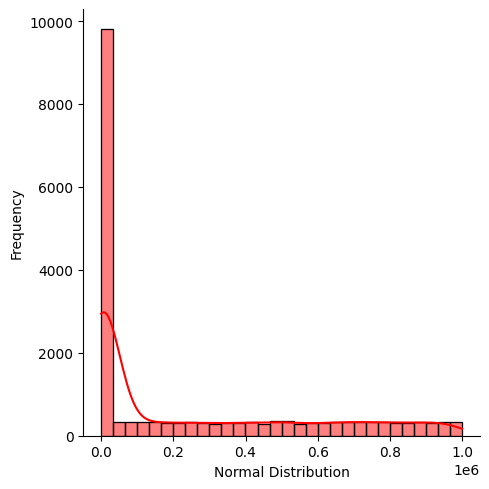

In [12]:
sns.displot(data['video_view_count'], bins=30, kde=True, color='red')
plt.xlabel('Normal Distribution')
plt.ylabel('Frequency')
plt.show()

In [15]:
not_verified = data[data["verified_status"] == "not verified"]["video_view_count"]
verified = data[data["verified_status"] == "verified"]["video_view_count"]
log_not_verified = np.log(not_verified)
log_verified = np.log(verified)

scipy.stats.levene(log_verified, log_not_verified, center='mean')

LeveneResult(statistic=1178.1201715850516, pvalue=1.3805284025726523e-250)

Since the p-value for the Levene test is less than 0.05, the hypothesis that the variances are equal is rejected.

In [17]:
scipy.stats.ttest_ind(log_verified, log_not_verified, equal_var = False)

TtestResult(statistic=-26.472493881638588, pvalue=2.0585161744395755e-126, df=1457.2935322485243)

Since the p-value is less than 0.05, we can conclude that there is a statistically significant difference in the mean video view count between verified and unverified accounts on TikTok.

The analysis shows that there is a statistically significant difference in the average view counts between videos from verified accounts and videos from unverified accounts. This suggests there might be fundamental behavioral differences between these two groups of accounts.

In [18]:
# Apply logistic model
data['verified_status_binary'] = data['verified_status'].apply(lambda x: 1 if x == 'verified' else 0)

data_log_transformed = data[['video_like_count', 'video_share_count', 'video_download_count', 
                             'video_comment_count']].apply(np.log1p)

data_log = data[['video_duration_sec', 'video_view_count']].apply(np.log)

data_combined_transformed = pd.concat([data_log_transformed, data_log, data['verified_status_binary']], axis=1)

X = data_combined_transformed[['video_duration_sec', 'video_view_count', 'video_like_count', 
                               'video_download_count', 'video_comment_count']]
y = data_combined_transformed['verified_status_binary']

X = sm.add_constant(X)

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.221550
         Iterations 8
                             Logit Regression Results                             
Dep. Variable:     verified_status_binary   No. Observations:                19084
Model:                              Logit   Df Residuals:                    19078
Method:                               MLE   Df Model:                            5
Date:                    Sun, 01 Sep 2024   Pseudo R-squ.:                 0.05651
Time:                            14:56:46   Log-Likelihood:                -4228.1
converged:                           True   LL-Null:                       -4481.3
Covariance Type:                nonrobust   LLR p-value:                3.216e-107
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4850      0.250     -1.942   

There is a significant negative correlation between video views and a user's verification status (coefficient -0.2554, p-value 0.000). This means that when the number of views of a video increases, the user's verification probability decreases. This may indicate that some unverified users are mass posting eye-catching content to get higher views, but this content does not represent trustworthiness or high quality.

There is a significant negative correlation between the number of video comments and verification status (coefficient -0.1163, p-value 0.006). This means that users with more comments are not necessarily verified users, and may even have fewer. This may indicate that a large number of reviews are not always positive and may contain a large amount of negative or spam content. Therefore, platforms should pay attention to the content quality of comments and take measures to reduce the impact of spam or malicious comments to maintain the health and safety of the community.

There is a significant positive correlation between the number of video likes and the user's verification status (coefficient 0.1043, p-value 0.011). This suggests that when a video gets more likes, the user is more likely to be verified. Platforms can leverage this to increase the visibility of trusted users by encouraging positive user interactions such as likes and comments. This may also indicate that likes are an important indicator of video content quality, and platforms can adjust content recommendation algorithms based on the number of likes to increase the exposure of high-quality content.